In [1]:
import os, sys
import numpy as np
import emcee
import zeus
import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyu
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import corner
from IPython.display import display, Math
from chainconsumer import ChainConsumer
import time

In [2]:
data_file = "HzTable_2020.dat"
z, Hz, errHz = np.genfromtxt(data_file, comments='#', usecols=(0,1,2), unpack=True, delimiter=',')
ref = np.genfromtxt(data_file, comments='#', usecols=(3), unpack=True, dtype=str, delimiter=',')

In [3]:
H0_fid = 67.37 
errH0_fid = 0.54
Omegam_fid = 0.308

H0_pl = H0_fid
Omegam_pl = Omegam_fid
planck=[H0_pl, Omegam_pl]

labels = [r"H_0", r"\Omega_m"]
lab = [r"$H_0$", r"$\Omega_m$"]

z0 = np.linspace(0,2.2,500)

ndim = 2

In [4]:

def Hzmodel(p):
    H0, Omegam = p
    return H0*np.sqrt(Omegam*(1+z)**3+(1-Omegam))

def lnlike(p):
    residual=Hz-Hzmodel(p)
    return -0.5 * np.sum(residual**2/errHz**2)

def lnflatprior_nested(u):
    uH0, uOmegam = u
    
    H0 = 50 * uH0 + 50
    Omegam = 0.98 * uOmegam + 0.99
    
    return H0, Omegam



In [5]:
rstate= np.random.default_rng(56101)
dsampler = dynesty.DynamicNestedSampler(lnlike, lnflatprior_nested, ndim=2,
                                        bound='multi', sample='unif', rstate=rstate)
dsampler.run_nested()
dres = dsampler.results

14774it [01:15, 194.94it/s, batch: 7 | bound: 5 | nc: 1 | ncall: 40318 | eff(%): 36.528 | loglstar: -31.256 < -25.837 < -26.518 | logz: -33.550 +/-  0.070 | stop:  0.932]          


<IPython.core.display.Math object>

<IPython.core.display.Math object>

The evidence is: 2.722883034932963e-15


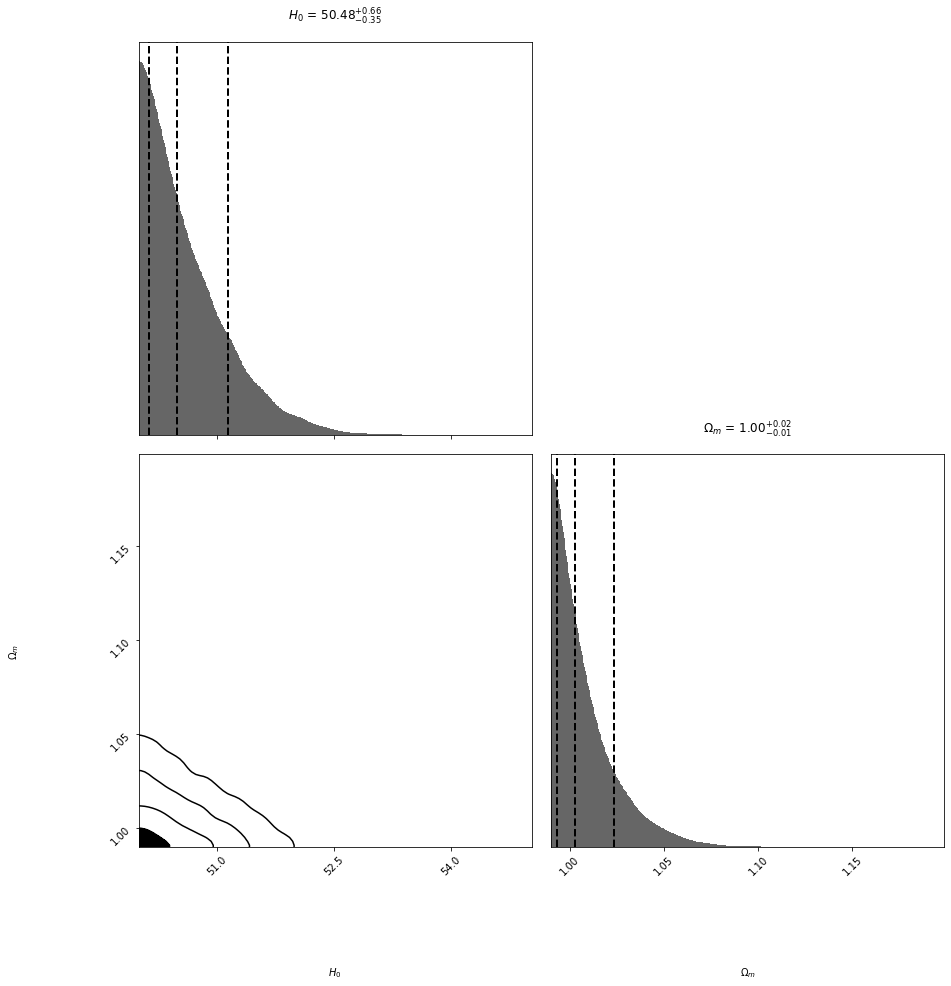

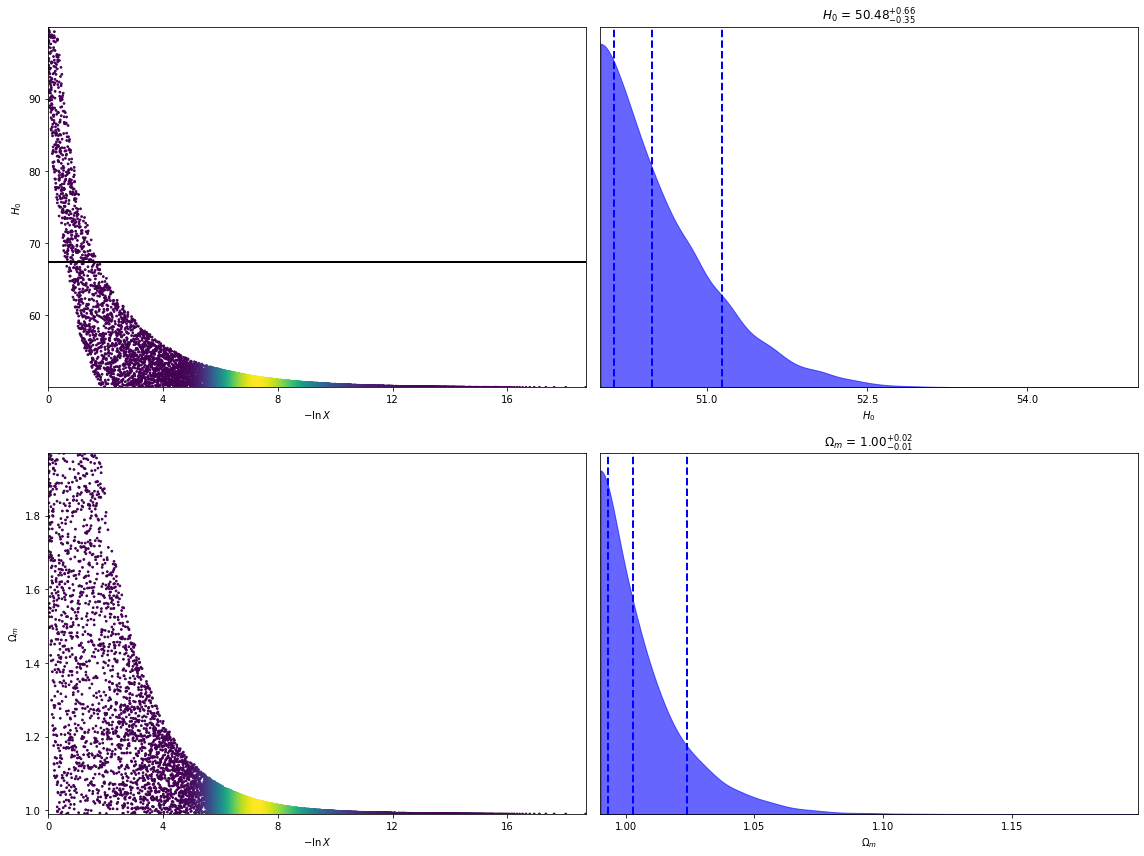

In [7]:
fig, axes = dyplot.cornerplot(dres, truths=planck, quantiles=(0.16, 0.5, 0.84), show_titles=True, 
                              title_kwargs={'y': 1.04}, labels=lab,
                              fig=plt.subplots(2, 2, figsize=(15, 15)), title_quantiles=(0.16, 0.5, 0.84))


fig, axes = dyplot.traceplot(dres, truths=planck, quantiles=(0.16, 0.5, 0.84), labels=lab,
                             fig=plt.subplots(2, 2, figsize=(16, 12)),
                             truth_color='black', show_titles=True, title_quantiles=(0.16, 0.5, 0.84),
                             trace_cmap='viridis')
fig.tight_layout()


for i in range(ndim):
    q=np.array([0.16,0.5,0.84])
    sampx = np.atleast_1d(dres.samples[:,i])
    weights=dres.importance_weights()
    weights = np.atleast_1d(weights)
    idx = np.argsort(sampx)  # sort samples
    sw = weights[idx]  # sort weights
    cdf = np.cumsum(sw)[:-1]  # compute CDF
    cdf /= cdf[-1]  # normalize CDF
    cdf = np.append(0, cdf)  # ensure proper span
    quantiles = np.interp(q, cdf, sampx[idx]).tolist()
    err = np.diff(quantiles)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(quantiles[1], err[0], err[1], labels[i])
    display(Math(txt))
    
        
    
print("The evidence is:",np.exp(dres.logz[len(dres.logz)-1]))